In [1]:
import gym
import numpy as np
import random

from scipy.stats import norm
from copy import deepcopy

from IPython import display
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

# Introduction

Sometimes, training with backpropagation can be time consumming and can end up in a local minimum. A good way to avoid it is to use Neuro-evolution like Genetic Algorithm to start the training and why not finish the training with classic backpropagation. 
In this Notebook, we are going to create a simple genetic algorithm able to solve the simple problem of "gym" library which is the <a href="https://gym.openai.com/envs/CartPole-v1/">cartpole</a> problem. The idea is to maintain a pole as much as possible on vertical axis by moving a cart placed below it.

Unfortunately, I cannot render the result in Notebook. In the past, I solve this problem using classique reinforcement learning and Q-learning. The training took around 10 min on CPU (more than 1h in GPU due to transfer time to GPU). And required around 1000 epoch x 10000 simulations. The result is available on youtube :

In [2]:
display.HTML('<iframe width="560" height="315" src="https://www.youtube.com/embed/MEzLFqB6HQ4" frameborder="0" allow="autoplay; encrypted-media" allowfullscreen></iframe>')

# Presentation

The environement is quite simple, we receive at every iteration the environement composed of 4 values :

* CartPole position
* CartPole Speed
* Pole angle
* Pole angular speed

And the expected output is :

* 0 : go to left
* 1 : go to right

In [5]:
import gym
env = gym.make('CartPole-v0')
observation = env.reset()
for t in range(1000):
    print(observation)
    action = env.action_space.sample()
    observation, reward, done, info = env.step(action)
    if done:
        print("Episode finished after {} timesteps".format(t+1))
        break

[-0.0293773  -0.02727688 -0.04773543 -0.00747832]
[-0.02992284  0.16849601 -0.047885   -0.31483203]
[-0.02655292 -0.02591228 -0.05418164 -0.03762666]
[-0.02707116 -0.22021709 -0.05493417  0.23748123]
[-0.0314755  -0.41451295 -0.05018455  0.51234285]
[-0.03976576 -0.60889344 -0.03993769  0.78879845]
[-0.05194363 -0.80344478 -0.02416172  1.06865419]
[-0.06801253 -0.60801172 -0.00278864  0.7684873 ]
[-0.08017276 -0.80309517  0.01258111  1.06029149]
[-0.09623466 -0.60814209  0.03378694  0.77158376]
[-0.10839751 -0.41350096  0.04921861  0.48972016]
[-0.11666752 -0.60928145  0.05901301  0.79749969]
[-0.12885315 -0.80516132  0.07496301  1.10814778]
[-0.14495638 -0.61110034  0.09712596  0.83989231]
[-0.15717839 -0.4174291   0.11392381  0.57926477]
[-0.16552697 -0.2240725   0.12550911  0.32453116]
[-0.17000842 -0.03094027  0.13199973  0.07391444]
[-0.17062722 -0.2276833   0.13347802  0.40515701]
[-0.17518089 -0.03468176  0.14158116  0.15735593]
[-0.17587453 -0.23151698  0.14472828  0.49114043]


# Modelization

As mentionned in the introduction, the idea is to train the model using Genetic Algorithm. 

#### Model

The model used will be a fully-connected Neural Network. The population will be composed of N individuals. All of them will have differents weight initially random.
Based on an evalution, a selection will be done  based on their fitness to solve the problem. Then a crossover will be performed on a few parts of remaining individuals. During a crossover, a swap of a matrix of the neural netwok will be performed. The matrix will be chosen randomly.
To finish a mutation will be performed on some individals. The value to change will be picked randomly and the change will be a factor between -10% / +10% of the initial value. 

This will be created in 3 classes (1 for NN, 1 for the GA and the last one for every individuals. This code may be used for other project later on and improved

In [11]:
class GeneticAlgorithm:
    def __init__(self, population, sample_try=5, selection_ratio=0.5, crossover_ratio=0.2, mutation_ratio=0.05):
        self.population_size = population
        self.selection_ratio = selection_ratio
        self.crossover_ratio = crossover_ratio
        self.mutation_ratio = mutation_ratio
        self.population = []
        self.sample_try = sample_try

    def create_init_population(self):
        self.complete_population()

    def eval_generation(self, show_result = False):
        result = np.array([x.score for x in self.population])
        d = {
            "num_indiv" : len(result),
            "max_fitness" : np.max(result),
            "min_fitness" : np.min(result),
            "avg_fitness" : np.mean(result),
            "std_fitness" : np.std(result)
        }
        if show_result:
            print("Number of Individual: {}".format(d["num_indiv"]))
            print("Best Score: {}".format(d["max_fitness"]))
            print("Average Score: {}".format(d["avg_fitness"]))
            print("Worst Score: {}".format(d["min_fitness"]))
            print("Deviation: {}".format(d["std_fitness"]))
            print("")
        return d

    def make_selection(self):
        choice_weight = [x.score for x in self.population]
        self.population = random.choices(
                                         population=self.population,
                                         weights=choice_weight,
                                         k=int(self.population_size * self.selection_ratio)
                                         )

    def make_crossover(self):
        sample_size = int(((self.crossover_ratio * self.population_size)//2)*2)
        parents = random.sample(self.population, sample_size)
        random.shuffle(parents)
        for i in range(0, sample_size, 2):
            child_1 = deepcopy(parents[i])
            child_2 = deepcopy(parents[i+1])
            swap_index = random.randrange(child_1.brain.nb_matrices)
            child_1.brain.tensors[swap_index], child_2.brain.tensors[swap_index] =\
            child_2.brain.tensors[swap_index], child_1.brain.tensors[swap_index]
            child_1.simulate()
            child_2.simulate()
            self.population.append(child_1)
            self.population.append(child_2)

    def make_mutation(self):
        k = int(self.population_size * self.selection_ratio) # only on old genomes
        for i in range(k):
            if random.random() < self.mutation_ratio:
                child = deepcopy(self.population[i])
                genome = child.brain.get_weight()
                mutate_index = random.randrange(len(genome))
                genome[mutate_index] *= (0.2 * random.random() - 0.1) # variation between -10% to +10%
                child.brain.set_weight(genome)
                child.simulate()
                self.population.append(child)

    def complete_population(self):
        while len(self.population) < self.population_size:
            indiv = Individual(self.sample_try)
            indiv.simulate()
            self.population.append(indiv)

    def get_best(self):
        return max(self.population, key=lambda x:x.score)


In [7]:
class Individual:
    def __init__(self, sample_try):
        self.score = 0
        self.brain = NeuralNetwork(4, 3, 2)
        self.sample_try = sample_try
        self.simulation_step = 200
        self.max_score = self.simulation_step * 2 * norm.pdf(0)

    @staticmethod
    def parameters(self):
        return self.brain.get_weight()

    def simulate(self):
        env = gym.make('CartPole-v0')
        score_list = []
        for i_episode in range(self.sample_try):
            observation = env.reset()
            current_score = 0
            for t in range(self.simulation_step):
                action = np.argmax(self.brain.predict(observation)[0])
                observation, reward, done, info = env.step(action)
                current_score += self.new_score(observation, reward)
                if done:
                    break
            score_list.append(current_score)
        self.score = sum(score_list)/len(score_list)
        self.score /= self.max_score

    def new_score(self, observation, reward):
        if reward == 1:
            score_pos = norm.pdf(observation[0])       # obs go from -2.4 to +2.4
            score_angle = norm.pdf(observation[2]*12)  # obs go from -0.21 to +0.21
            return score_pos + score_angle
        else:
            return reward

    def render(self):
        frames = []
        env = gym.make('CartPole-v0')
        observation = env.reset()
        for t in range(self.simulation_step):
            env.render()
            action = np.argmax(self.brain.predict(observation)[0])
            observation, reward, done, info = env.step(action)
            if done:
                break     
        env.close()

In [8]:
class NeuralNetwork:
    def __init__(self, input, intermediate, output):
        if isinstance(intermediate, list):
            self.sizes = [input] + intermediate + [output]
        elif isinstance(intermediate, int):
            self.sizes = [input] + [intermediate] + [output]

        self.tensors = []
        self.nb_matrices = len(self.sizes)-1
        self.nb_params = 0
        for i in range(self.nb_matrices):
            transfer = np.random.random(size=(self.sizes[i], self.sizes[i+1]))
            self.tensors.append( transfer )
            self.nb_params += self.sizes[i] * self.sizes[i+1]

    def __repr__(self):
        return "NN {}".format(self.sizes)

    def set_weight(self, w):
        for i in range(self.nb_matrices):
            row, col = self.tensors[i].shape
            self.tensors[i] = np.array(w[:(row*col)]).reshape(row, col)
            w = w[(row * col):]

    def get_weight(self):
        w = []
        for i in range(self.nb_matrices):
            w += list(self.tensors[i].flatten())
        return w

    def predict(self, input):
        input = np.matrix(input, dtype=np.float32).reshape(-1)
        for tensor in self.tensors:
            input = np.dot(input, tensor)
        return input

As the exercice is quite simple, we should not select a too high number of individuals (10) and we can try only with 10 generations.

In [18]:
nb_generation = 10

ag = GeneticAlgorithm(population=10)
ag.create_init_population()
ag.eval_generation(show_result = True)
for i in range(nb_generation):
    ag.make_selection()
    ag.make_crossover()
    ag.make_mutation()
    if i < nb_generation -1:
        ag.complete_population()
ag.eval_generation(show_result = True)

best = ag.get_best()

Number of Individual: 10
Best Score: 0.09588223459247369
Average Score: 0.04265764402275665
Worst Score: 0.030991280655387244
Deviation: 0.017921791509425227

Number of Individual: 8
Best Score: 0.9983445172473737
Average Score: 0.9349993275342539
Worst Score: 0.5070965668369595
Deviation: 0.16174462108642393



# Results

We can see that the initial score is quite low in ration of the maximum reachable 
* best score is only getting 10%
* worst score is 3%
* average score is 4%

After 10 Epochs, the improvement is huge with
* best score is only getting 99.8%
* worst score is 50%
* average score is 93%

Unfortunately, I didn't succeed to make the visulaisation into jupyter Notebook. As a result, I've generated 2 video a 1st iteration and 10th iteration only with the best individual. 

* @ iteration 0, the score is 64.6%
* @ iteration 10, the score is 99.72%

In [19]:
import io
import base64
from IPython.display import HTML

video_start = io.open('generation1.mp4', 'r+b').read()  # fitness = 0.6460
video_end = io.open('generation10.mp4', 'r+b').read()   # fitness = 0.9972
HTML(data='''<video alt="iter1" controls>
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>
             <video alt="iter10" controls>
                <source src="data:video/mp4;base64,{1}" type="video/mp4" />
             </video>'''.format(base64.b64encode(video_start).decode('ascii'), base64.b64encode(video_end).decode('ascii')))

We can also look at how Genetic Algorithm is improving population fitness during training

In [26]:
nb_generation = 10

results = []

ag = GeneticAlgorithm(population=10)
ag.create_init_population()
results.append(ag.eval_generation())
for i in range(nb_generation):
    ag.make_selection()
    ag.make_crossover()
    ag.make_mutation()
    if i < nb_generation -1:
        ag.complete_population()
    results.append(ag.eval_generation())

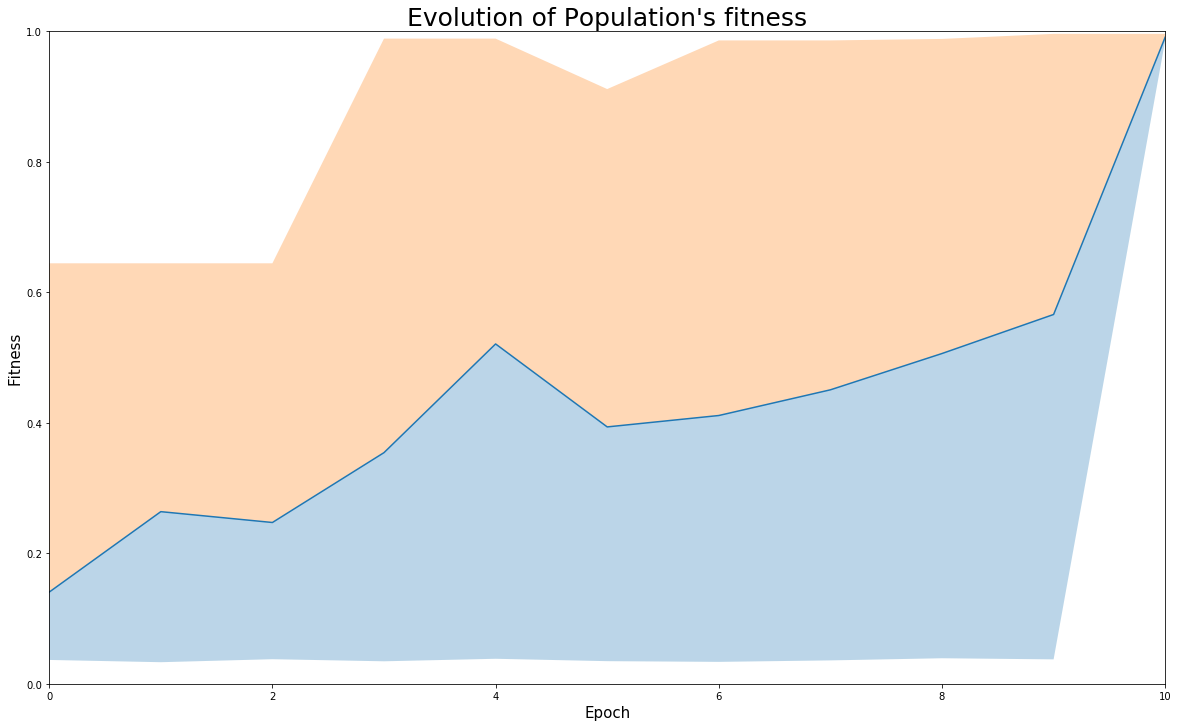

In [27]:
lower = [x["min_fitness"] for x in results]
upper = [x["max_fitness"] for x in results]
average = [x["avg_fitness"] for x in results]

fig, ax = plt.subplots(figsize=(20,12))
epochs = list(range(len(results)))
ax.plot(epochs, average)
ax.fill_between(epochs, lower, average, alpha=0.3)
ax.fill_between(epochs, upper, average, alpha=0.3)
plt.ylim(0, 1)
plt.xlim(0, len(results)-1)
plt.title("Evolution of Population's fitness", fontsize=25)
plt.xlabel("Epoch", fontsize=15)
plt.ylabel("Fitness", fontsize=15)
plt.show()

# Analysis

From our population, we can get the best individual and check the prediction for all points in space to try to analysis the behavior. Every range will be splitted in 21 parts and simulation will be performed for every settings

In [28]:
cart_pos = np.linspace(-2, 2, 21)
cart_speed = np.linspace(-1.5, 1.5, 21)
pole_ang = np.linspace(-0.2, +0.2, 21)
pole_speed = np.linspace(-2, 2, 21)

In [29]:
X = []
y = []

for i in range(21):
    for j in range(21):
        for k in range(21):
            for l in range(21):
                setup = [cart_pos[i], cart_speed[j], pole_ang[k], pole_speed[l]]
                X.append(setup)
                y.append(best.brain.predict(setup))
                
X = np.array(X, dtype=np.float32)
y = np.array(y, dtype=np.float32).reshape(-1, 2)

In [30]:
np.savez("prediction.npz", x=X, y=y)

#### Visualization

Now we have all output based on a good quantity of environments values. We can plot this and try to understand it

In [31]:
data = np.load("prediction.npz")
X = data["x"]
y = data["y"]

In [32]:
condition = np.where( (X[:, 0] == 0) & (X[:, 3] == 0) )

output = np.argmax(y[condition], axis=1).reshape(-1,1)
x_ = X[condition][:, 2].reshape(-1,1)
y_ = X[condition][:, 1].reshape(-1,1)
z_ = X[condition][:, 0].reshape(-1,1)
a_ = X[condition][:, 3].reshape(-1,1)

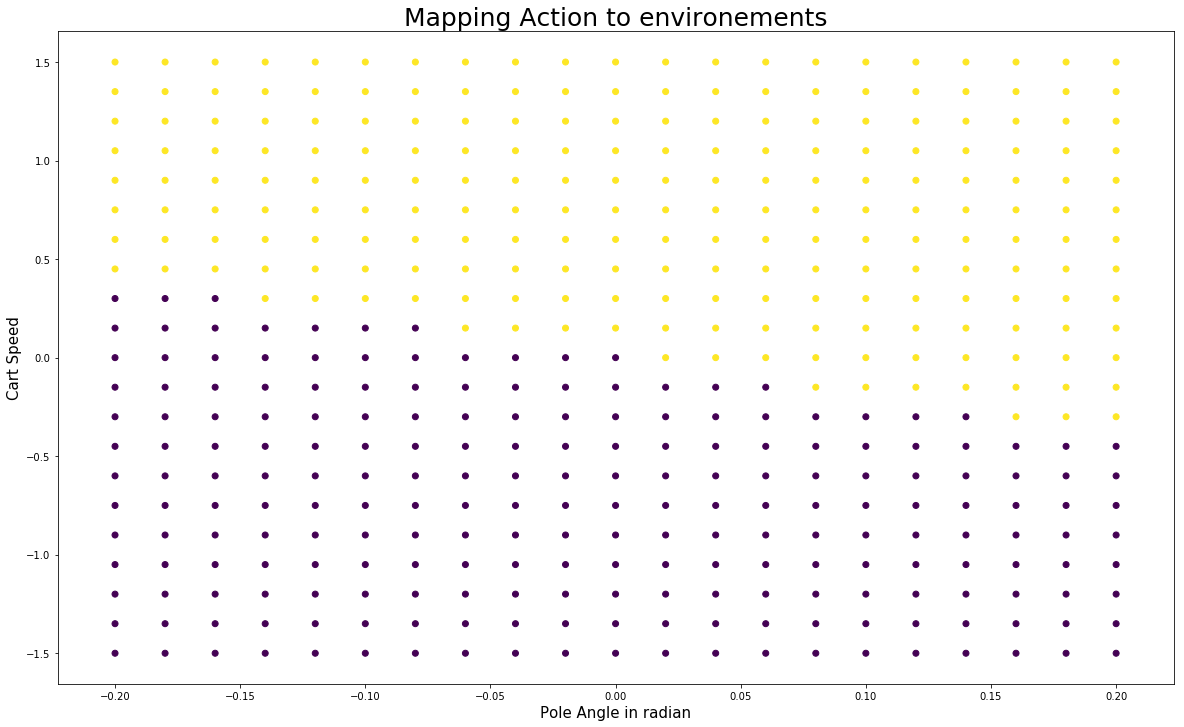

In [33]:
plt.figure(figsize=(20, 12))
plt.scatter(x_, y_, c = output)
plt.xlabel("Pole Angle in radian", fontsize = 15)
plt.ylabel("Cart Speed", fontsize = 15)
plt.title("Mapping Action to environements", fontsize = 25)
plt.show()

We can see that the command is linear between the cart speed and the angle. This is logical, if the cart goes fast to 1 direction, we can correct a bigger angle. if the pole is perfectly vertical, we should not move. Nevertheless, this visualisation is done for a fixed anglar speed of the pole at 0 and the cart position at 0 too. We can imagine that those values have also an impact. We can try to add a dimension and plot it in 3D

In [34]:
condition = np.where( (X[:, 3] == 0) )

output = np.argmax(y[condition], axis=1).reshape(-1,1)
x_ = X[condition][:, 2].reshape(-1,1)
y_ = X[condition][:, 1].reshape(-1,1)
z_ = X[condition][:, 0].reshape(-1,1)
a_ = X[condition][:, 3].reshape(-1,1)

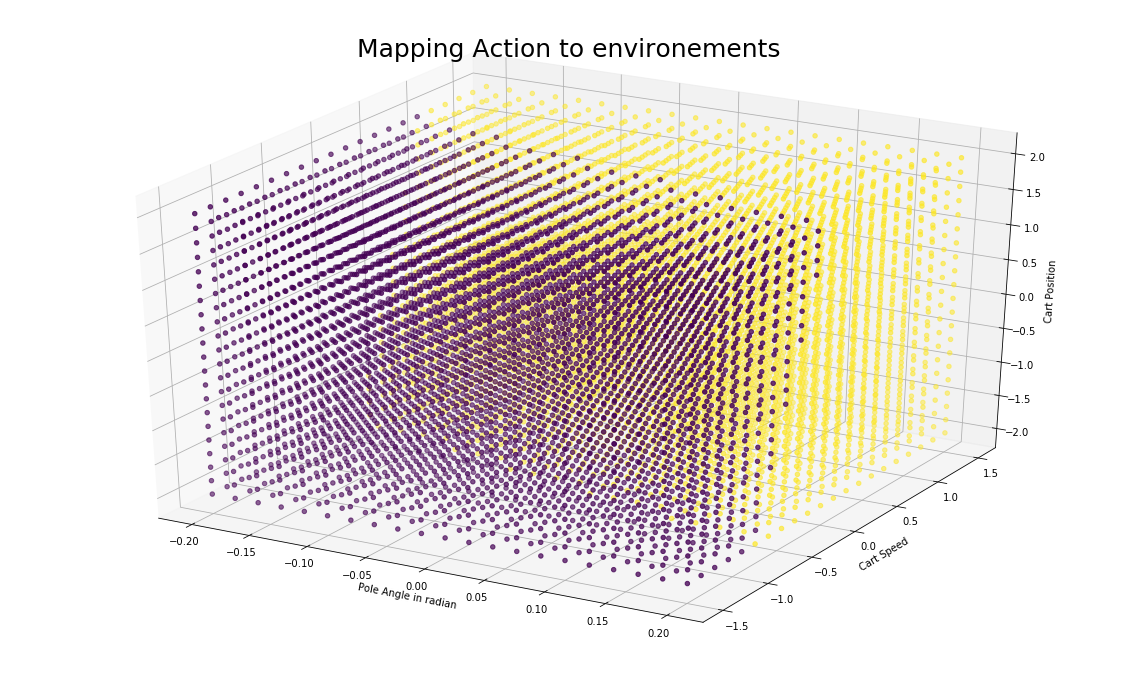

In [35]:
fig = plt.figure(figsize=(20,12))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(x_, y_, z_, c=output)

ax.set_xlabel('Pole Angle in radian')
ax.set_ylabel('Cart Speed')
ax.set_zlabel('Cart Position')
ax.set_title("Mapping Action to environements", fontsize = 25)

plt.show()

It seems that the NN is fully linear. As a result, we may train for this NN a linear Classifier to perform the task with less computation in the future.
Let's check is this is true ?..

# Simple Classifier

Now, let's train a Linear Model with those datas and check the accuracy compare to the NN outcome. To finish if the result is good, we can try to run the same set of simulation with both models and check how they perform on this task.

In [36]:
from sklearn.linear_model import LogisticRegression
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

X_mdl, y_mdl = shuffle(X, np.argmax(y, axis=1))
X_train, X_test, y_train, y_test = train_test_split(X_mdl, y_mdl, test_size=0.20)

mdl = LogisticRegression()
mdl.fit(X_train, y_train)
mdl.score(X_test, y_test)

0.9978918682674757

99.8 % accuracy is quite good. That means that the NN is really close to a Linear model (logical as we have only 3 layers).

In [37]:
mdl.coef_ 

array([[-4.57535272, 23.76273461, 45.12355333, 18.93885085]])

In [38]:
mdl.intercept_ 

array([0.0009253])

In [39]:
env = gym.make('CartPole-v0')
env.seed(0)
score_list = []
for i in range(50):
    observation = env.reset()
    score = 0
    for t in range(200):
        action = mdl.predict([observation])[0]
        observation, reward, done, info = env.step(action)
        if reward == 1:
            score_pos = norm.pdf(observation[0])       # obs go from -2.4 to +2.4
            score_angle = norm.pdf(observation[2]*12)  # obs go from -0.21 to +0.21
            score += score_pos + score_angle
        if done:
#             print("Episode finished after {} timesteps (score : {:.4f})".format(t+1, score))
            break
    score_list.append(score/(200 * 2 * norm.pdf(0)))

In [40]:
env = gym.make('CartPole-v0')
env.seed(0)
score_list_2 = []
for i in range(50):
    observation = env.reset()
    score = 0
    for t in range(200):
        action = np.argmax(best.brain.predict(observation)[0])
        observation, reward, done, info = env.step(action)
        if reward == 1:
            score_pos = norm.pdf(observation[0])       # obs go from -2.4 to +2.4
            score_angle = norm.pdf(observation[2]*12)  # obs go from -0.21 to +0.21
            score += score_pos + score_angle
        if done:
#             print("Episode finished after {} timesteps (score : {:.4f})".format(t+1, score))
            break
    score_list_2.append(score/(200 * 2 * norm.pdf(0)))

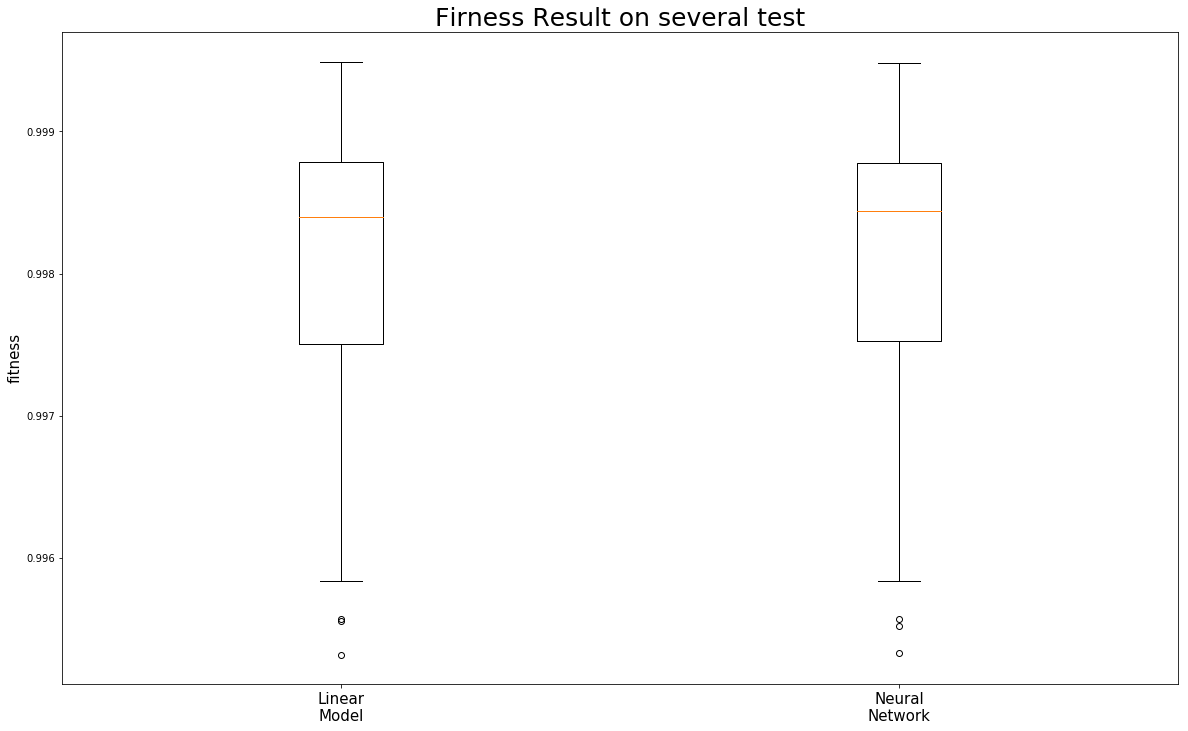

In [41]:
plt.figure(figsize=(20,12))
plt.boxplot([score_list, score_list_2])
plt.xticks([1, 2], ['Linear\nModel', 'Neural\nNetwork'], fontsize=15)
plt.ylabel("fitness", fontsize=15)
plt.title("Firness Result on several test", fontsize=25)
plt.show()

# Conclusion

We saw during this Notebook how to train a NN with a Genetic Algorithm instead of Gradient Descent. In only 10 Epochs with 10 individuals evaluated on 5 simualtions, we succeed to have a correlty trained model with a fitness of 99.8%. We saw during enalysis that the model is quite Linear and we we able to train a linear model to succeed on this task. Based on 50 simulations, we can see that the NN is juste slightly better than the Linear Model but not by much. This can be explained because with very small values, model is probably not exaclty linear to compensation small moves. 